#TD 5 : Introduction to PySpark MLlib


source: MLlib official documentation https://spark.apache.org/docs/latest/ml-classification-regression.html

In [1]:
!pip install --upgrade pyspark==3.5.4 py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 14.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849766 sha256=112dcde8082e038460df62abf237bb88fc467d3b0e79541c68ff3bdf8c302767
  Stored in directory: /root/.cache/pip/wheels/8d/28/22/5dbae8a8714ef046cebd320d0ef7c92f5383903cf854c15c0c
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9
    Uninstalling py4j-0.10.9:
      Successfully uninstalled py4j-0.10.9
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.0.3
    Uninstalling pyspark-3.0.3:
      Successfully uninstalled pyspark-3.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyspark-stubs 3.0.0.post

In [2]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

##Machine learning
Machine learning is a branch of artificial intelligence (AI) and computer science that focuses on using data and algorithms to imitate the way that humans learn, gradually improving its accuracy.
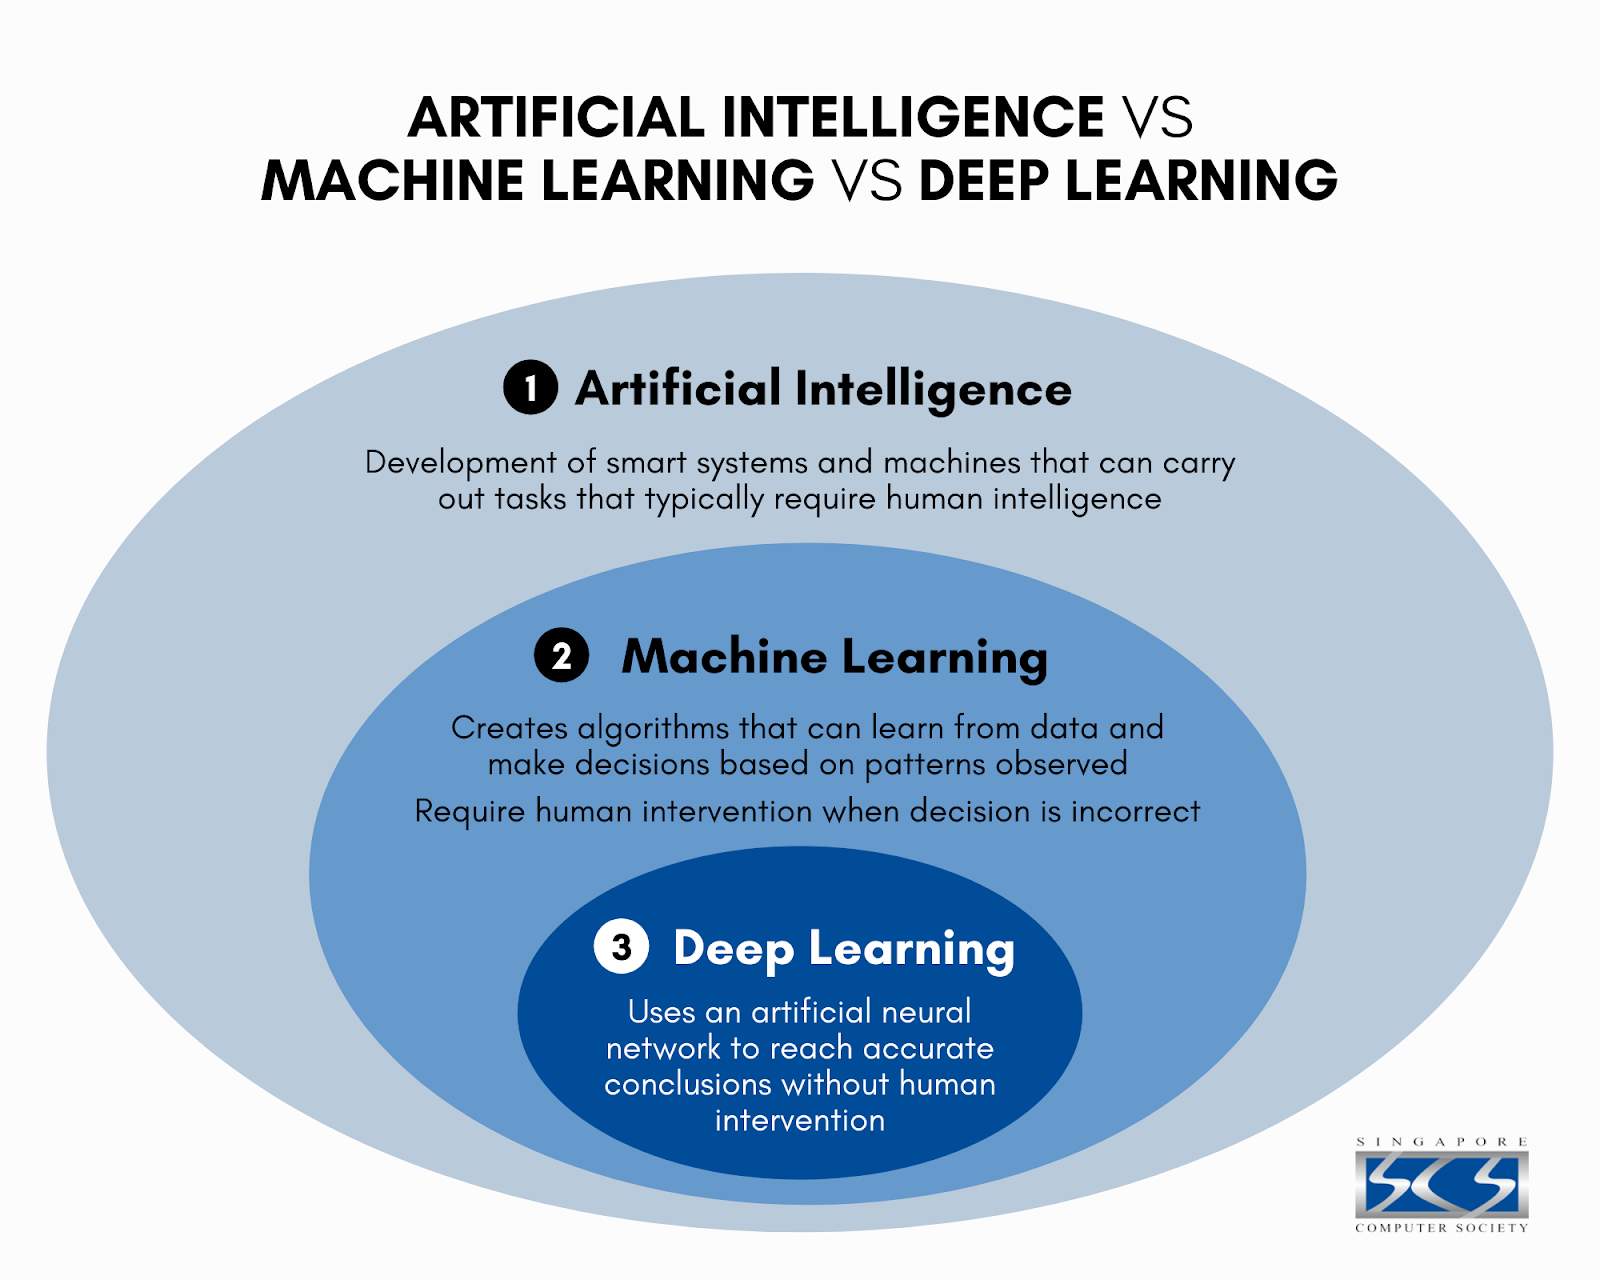


Machine learning is divided into three branches, supervised learning relies on labeled data to learn a mapping from inputs to outputs, unsupervised learning discovers hidden patterns or structures in unlabeled data, and reinforcement learning learns to make decisions through interaction with an environment based on rewards or penalties.

Decision tree classifier, Gradient boosting and Random Forest are all supervised learning methods, indeed in the dataset we have the labels.
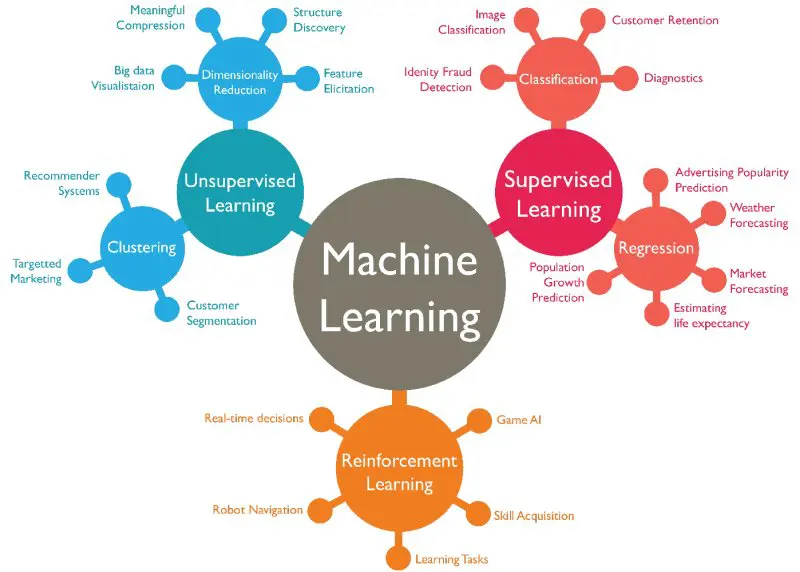

##Dataset

This dataset is formatted in a sparse representation, commonly used in machine learning contexts to represent high-dimensional data efficiently. Each line in the dataset represents a data point, and the label for classification is the first element in each line (either 0 or 1). The rest of each line consists of feature-value pairs, where the feature index is followed by a colon and then the value of that feature for the particular data point.

For example:

*   "128:51" means feature 128 has a value of 51.
*   "159:124" means feature 159 has a value of 124.

The dataset seems to be describing handwritten digits, where each feature represents a pixel intensity of an image.

The labels (0 or 1) may represent different classes or categories of handwritten digits.


#Different classifiers
## Decision Tree VS Gradient-boosted tree VS Random forest

In [3]:
#BostonHousing.csv a telecharger sur moodle
# from google.colab import files
# files.upload()
!wget -q https://raw.githubusercontent.com/apache/spark/master/data/mllib/sample_libsvm_data.txt

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier

In [84]:
# Load the data stored in LIBSVM format as a DataFrame.
data = spark.read.format("libsvm").load("sample_libsvm_data.txt")
#Dataset Analysis
# Check the final label distribution
print("Dataset set label distribution:")
data.groupBy("label").count().show()
#print the data to understand the structure
print("DATASET")
print('rows',data.count())
data.show(5)

# Split the data into training and test sets (30% held out for testing)
#take a look to the function randomSplit()
(trainingData, testData) = data.randomSplit([0.7, 0.3])
print("TRAIN")
print('rows',trainingData.count())
trainingData.show(5)
print("TEST")
print('rows',testData.count())
testData.show(5)

print("Training set label distribution:")
trainingData.groupBy("label").count().show()
print("Test set label distribution:")
testData.groupBy("label").count().show()

Dataset set label distribution:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|   43|
|  1.0|   57|
+-----+-----+

DATASET
rows 100
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(692,[127,128,129...|
|  1.0|(692,[158,159,160...|
|  1.0|(692,[124,125,126...|
|  1.0|(692,[152,153,154...|
|  1.0|(692,[151,152,153...|
+-----+--------------------+
only showing top 5 rows

TRAIN
rows 76
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(692,[95,96,97,12...|
|  0.0|(692,[100,101,102...|
|  0.0|(692,[121,122,123...|
|  0.0|(692,[122,123,124...|
|  0.0|(692,[122,123,148...|
+-----+--------------------+
only showing top 5 rows

TEST
rows 24
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(692,[98,99,100,1...|
|  0.0|(692,[124,125,126...|
|  0.0|(692,[126,127,128...|
|  0.0|(692,[129,130,131...|
|  0.0|(692,[150,151,152...|
+-----+--------------------+
only s

###Decision tree classifier

A decision tree classifier lets you make non-linear decisions, using simple linear questions.

A decision tree classifier deals with different parameters and, depending on the response over each parameter, splits the data until a final answer is reached.

What the machine does is to select the best attribute that can split the data and can give as much information as possible. That is how the machine selects the best decision tree among many.

Although, it is important to understand that the more we split the data the more we risk overfitting the data.

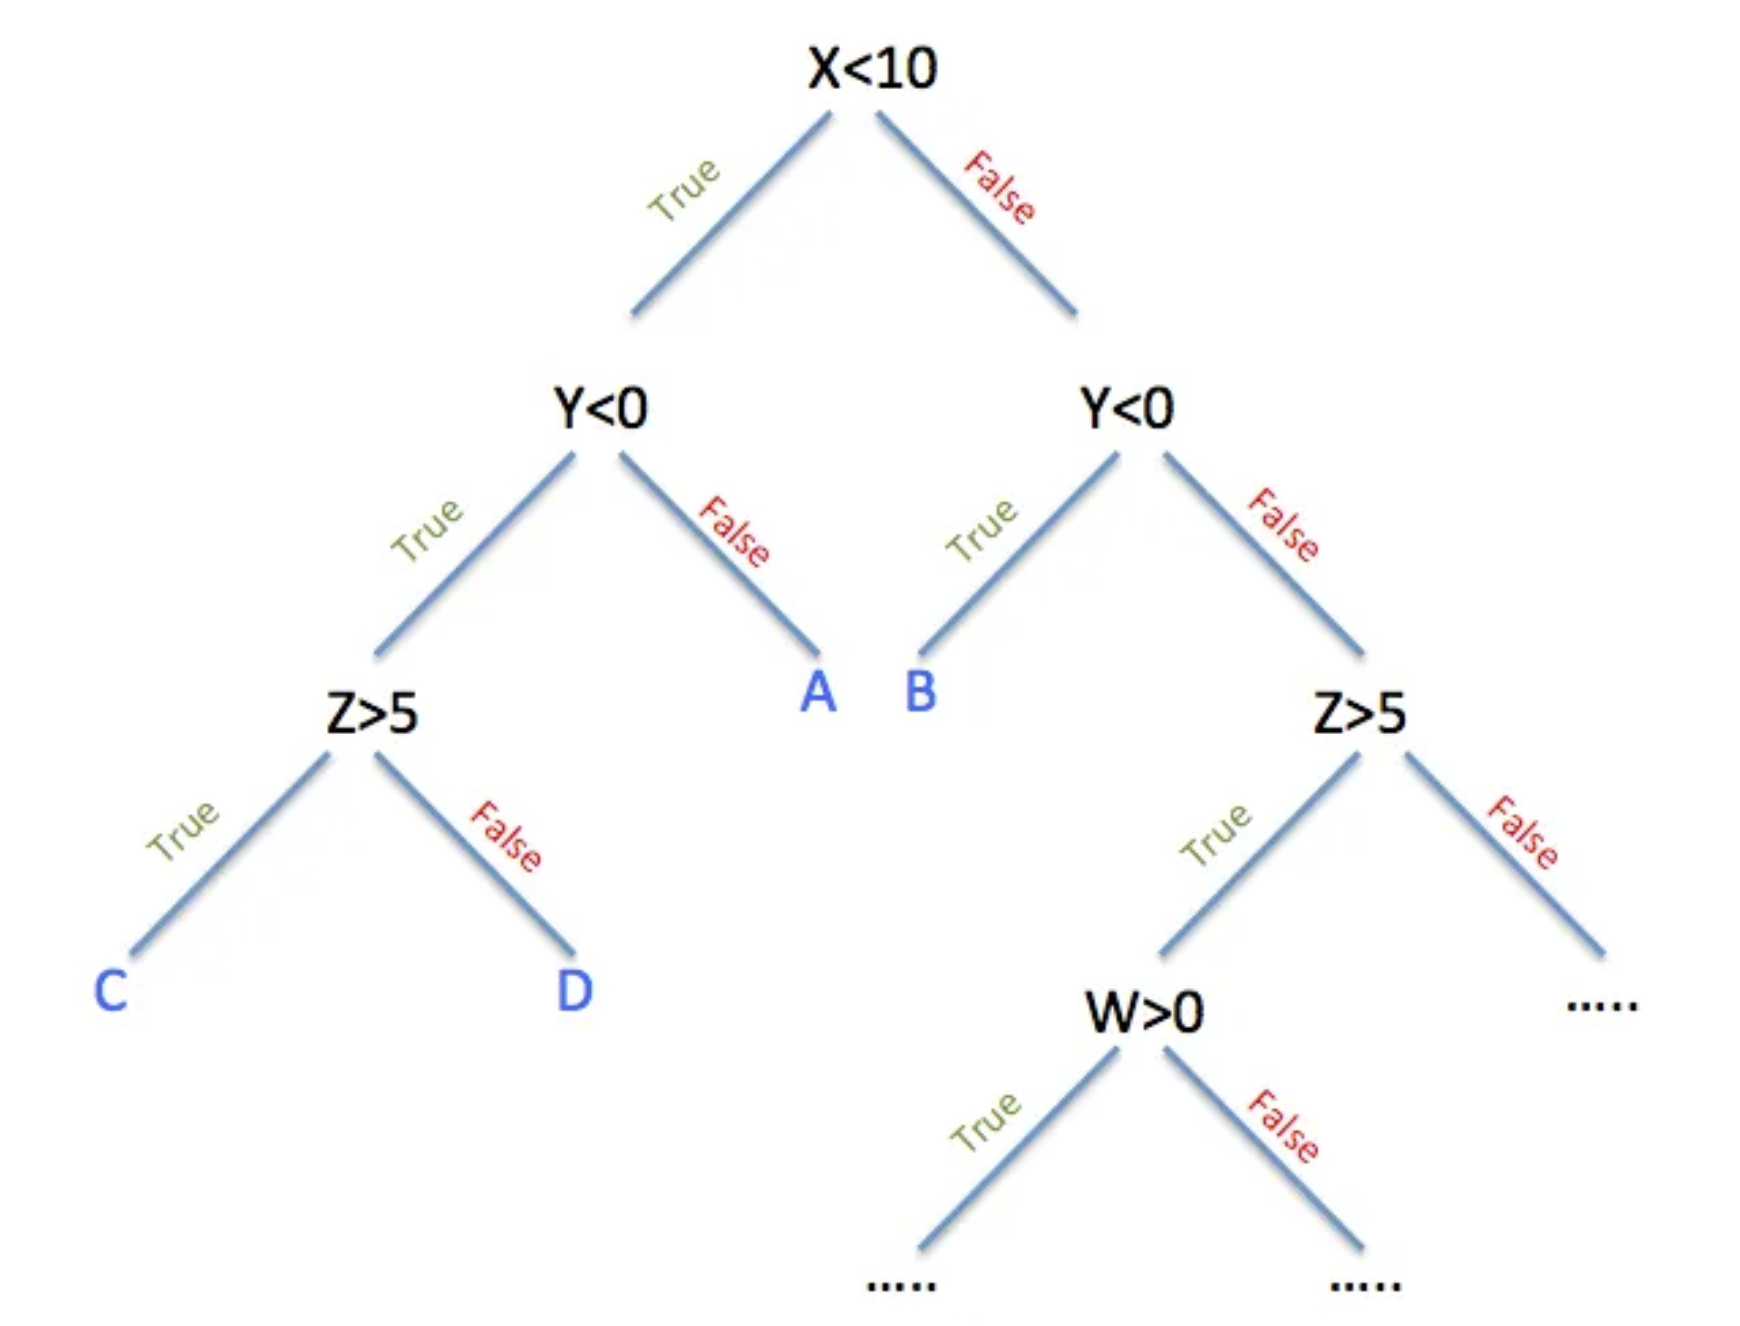

In [85]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
#More specifically:
#StringIndexer maps a string column of labels to an ML column of label indices. If the input column is
#numeric, we cast it to string and index the string values. The indices are in [0, numLabels).
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)


# Train a DecisionTree model.
#take a look to DecisionTreeClassifier()
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
#Pipeline provide a uniform set of high-level APIs built on top of DataFrames that help
#users create and tune practical machine learning pipelines.
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictionsDT = model.transform(testData)

# Select example rows to display.
predictionsDT.select("prediction", "indexedLabel", "features").show()

# Select (prediction, true label) and compute test error
#Evaluator for Multiclass Classification, which expects input columns: prediction, label,
#weight (optional) and probabilityCol (only for logLoss).
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionsDT)
print("Accuracy = %g" % (accuracy))

#in the pipeline there are different stages, we want to print only the tree, so we will choose the 2nd stage
treeModel = model.stages[2]
# summary only
print(treeModel)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         1.0|(692,[98,99,100,1...|
|       1.0|         1.0|(692,[124,125,126...|
|       1.0|         1.0|(692,[126,127,128...|
|       1.0|         1.0|(692,[129,130,131...|
|       1.0|         1.0|(692,[150,151,152...|
|       1.0|         1.0|(692,[151,152,153...|
|       1.0|         1.0|(692,[152,153,154...|
|       1.0|         1.0|(692,[152,153,154...|
|       1.0|         1.0|(692,[153,154,155...|
|       1.0|         1.0|(692,[153,154,155...|
|       1.0|         1.0|(692,[154,155,156...|
|       1.0|         0.0|(692,[99,100,101,...|
|       0.0|         0.0|(692,[124,125,126...|
|       0.0|         0.0|(692,[126,127,128...|
|       0.0|         0.0|(692,[126,127,128...|
|       0.0|         0.0|(692,[126,127,128...|
|       0.0|         0.0|(692,[128,129,130...|
|       0.0|         0.0|(692,[128,129,130...|
|       0.0| 

###Gradient-boosted tree classifier

Learning algorithm for a gradient boosted trees model for classification or regression.

Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting.

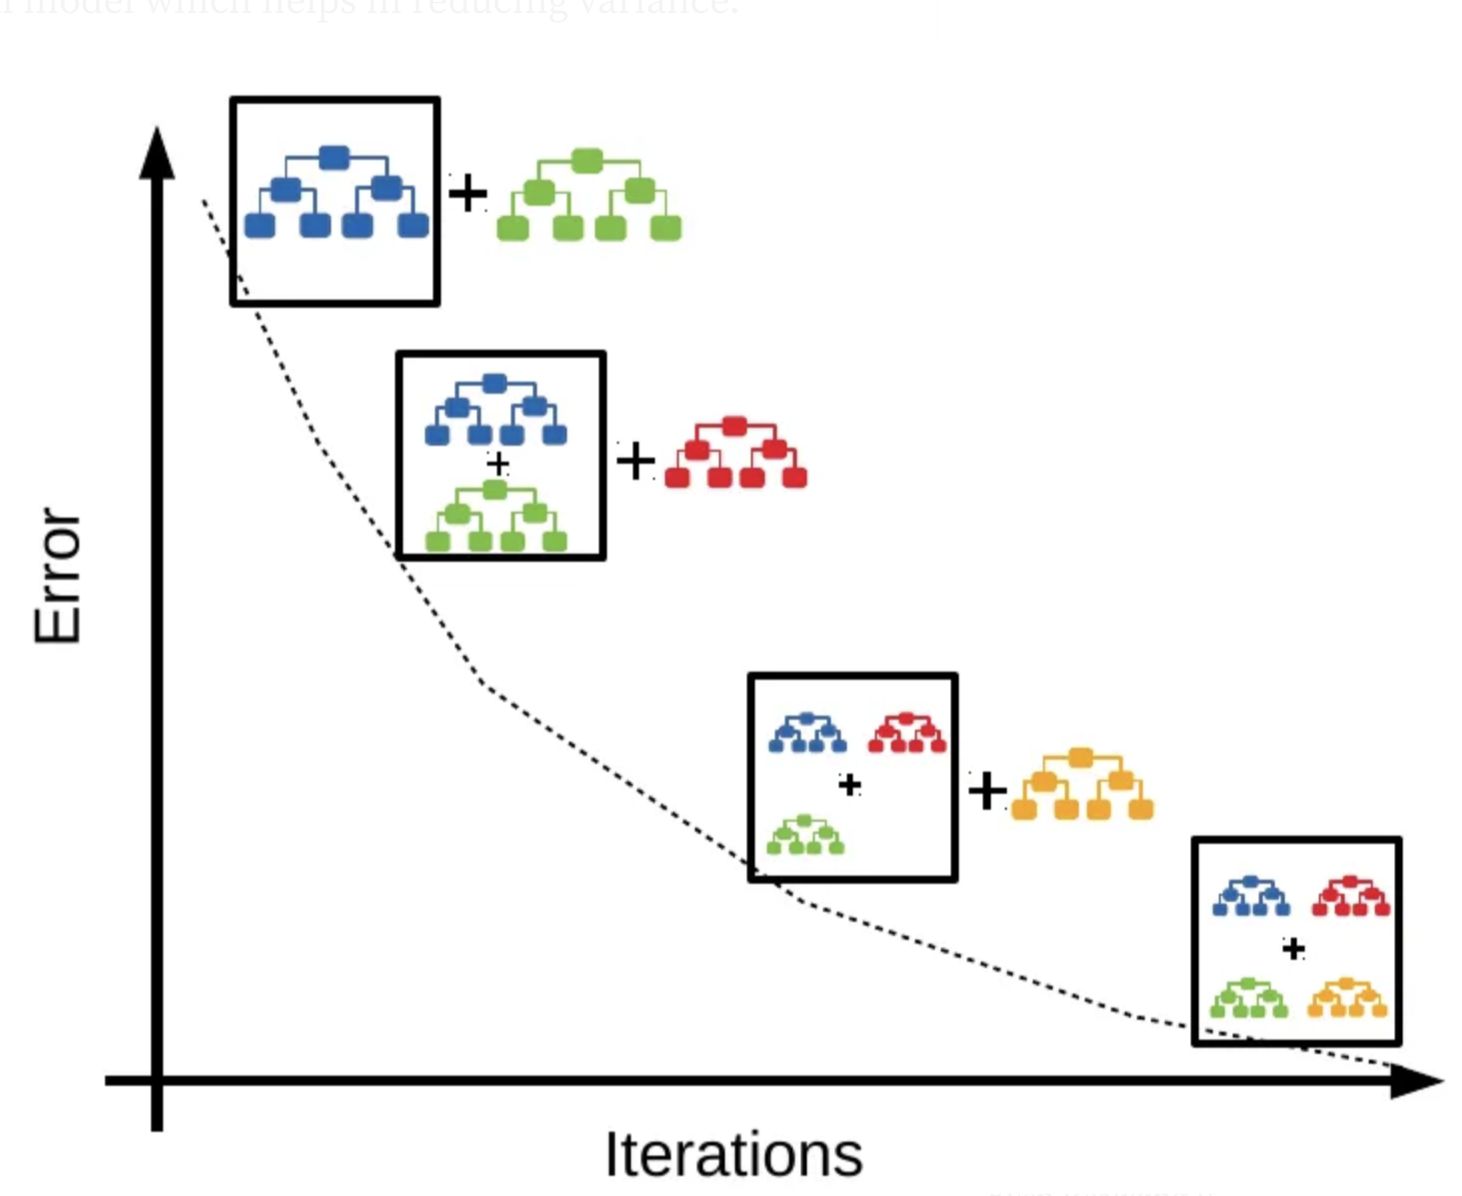

In [87]:
# Train a GBT model.
# Take a look to GBTClassifier, use a max iteration of 10

gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=20)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictionsGBT = model.transform(testData)

# Select example rows to display.
predictionsGBT.select("prediction", "indexedLabel", "features").show()

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionsGBT)
print("Accuracy = %g" % (accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         1.0|(692,[98,99,100,1...|
|       1.0|         1.0|(692,[124,125,126...|
|       1.0|         1.0|(692,[126,127,128...|
|       1.0|         1.0|(692,[129,130,131...|
|       1.0|         1.0|(692,[150,151,152...|
|       1.0|         1.0|(692,[151,152,153...|
|       1.0|         1.0|(692,[152,153,154...|
|       1.0|         1.0|(692,[152,153,154...|
|       1.0|         1.0|(692,[153,154,155...|
|       1.0|         1.0|(692,[153,154,155...|
|       1.0|         1.0|(692,[154,155,156...|
|       1.0|         0.0|(692,[99,100,101,...|
|       0.0|         0.0|(692,[124,125,126...|
|       0.0|         0.0|(692,[126,127,128...|
|       0.0|         0.0|(692,[126,127,128...|
|       0.0|         0.0|(692,[126,127,128...|
|       0.0|         0.0|(692,[128,129,130...|
|       0.0|         0.0|(692,[128,129,130...|
|       0.0| 

Given that maxIter specifies the maximum number of boosting iterations or trees to build in the GBT algorithm. Each iteration adds a new decision tree to the ensemble model.

Increasing maxIter may lead to overfitting, so to worst results in the testing. To avoid this, you should create a validation set as well to check how the model is working on new data and change the hyperparameters.



###Random forest classifier

A random forest is a group of decision trees. However, there are some differences between the two. A decision tree tends to create rules, which it uses to make decisions, but  they usually have low bias and high variance, so tends to overfit the data. A random forest will randomly choose features and make observations, build a forest of decision trees, and then average out the results.

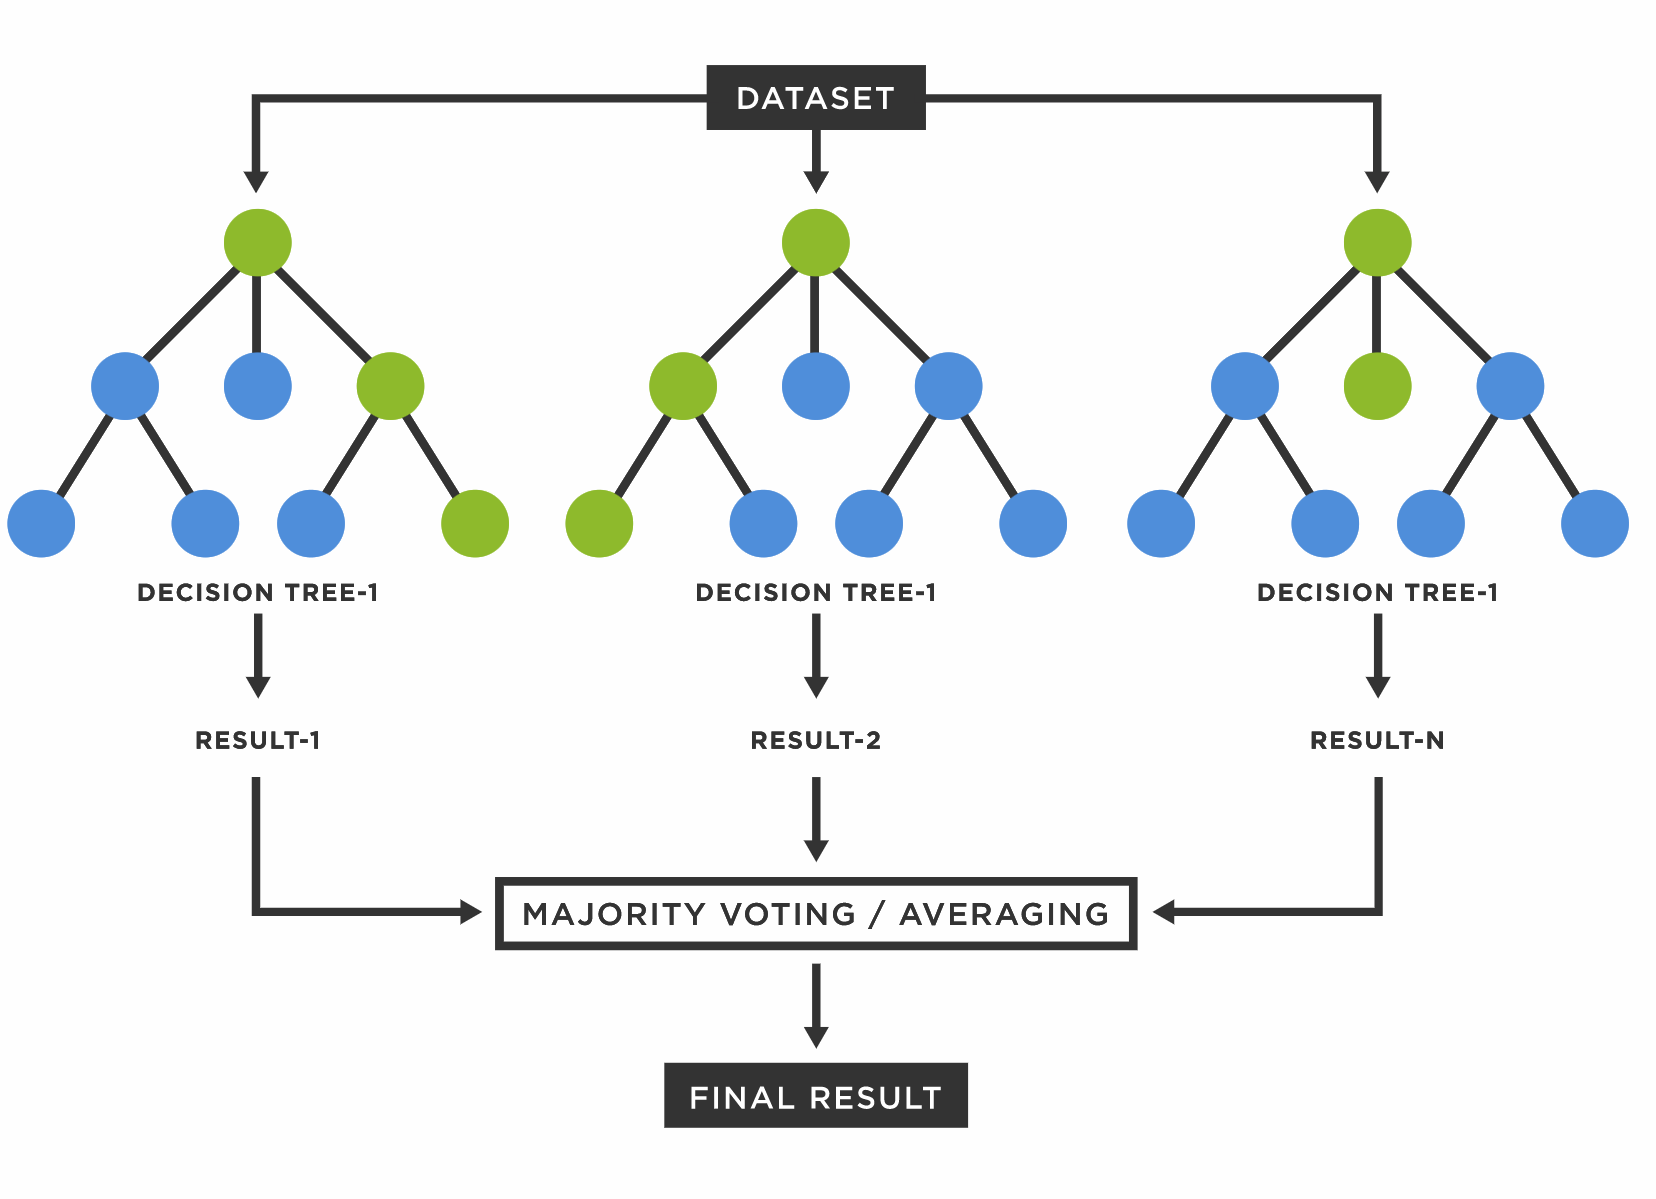

In [86]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictionsRF = model.transform(testData)

# Select example rows to display.
predictionsRF.select("predictedLabel", "label", "features").show()

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionsRF)
print("Accuracy = %g" % (accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(692,[98,99,100,1...|
|           0.0|  0.0|(692,[124,125,126...|
|           0.0|  0.0|(692,[126,127,128...|
|           0.0|  0.0|(692,[129,130,131...|
|           0.0|  0.0|(692,[150,151,152...|
|           0.0|  0.0|(692,[151,152,153...|
|           0.0|  0.0|(692,[152,153,154...|
|           0.0|  0.0|(692,[152,153,154...|
|           0.0|  0.0|(692,[153,154,155...|
|           0.0|  0.0|(692,[153,154,155...|
|           0.0|  0.0|(692,[154,155,156...|
|           1.0|  1.0|(692,[99,100,101,...|
|           1.0|  1.0|(692,[124,125,126...|
|           1.0|  1.0|(692,[126,127,128...|
|           1.0|  1.0|(692,[126,127,128...|
|           1.0|  1.0|(692,[126,127,128...|
|           1.0|  1.0|(692,[128,129,130...|
|           1.0|  1.0|(692,[128,129,130...|
|           1.0|  1.0|(692,[129,130,131...|
|           1.0|  1.0|(692,[129,

numTrees is a hyperparameter that defines the number of decision trees to be used in the random forest ensemble. Each decision tree in the ensemble is trained independently on a random subset of the training data, and the final prediction is made by aggregating the predictions of all the trees (e.g., averaging for regression, or voting for classification).

numTrees parameter typically improves the performance of the random forest model, up to a certain point. More trees allow the model to capture more complex patterns in the data and reduce overfitting, resulting in better generalization to unseen data.

However, there is a trade-off between model performance and computational cost. Training and predicting with more trees require more computational resources and time. Therefore, you need to consider your computational constraints when choosing the value of numTrees.

The optimal value for numTrees depends on the specific dataset and problem you are working on. It's common to tune this hyperparameter using techniques like cross-validation or grid search to find the value that maximizes the model's performance on a validation dataset.

The increase of numTrees can lead to overfitting although the risk is not as high as with other algorithms.

Overfitting occurs when the model learns to capture noise or random fluctuations in the training data, rather than the underlying true patterns. With Random Forests, each tree in the ensemble is trained on a random subset of the data, and they are combined to make predictions. This randomness helps to reduce overfitting compared to individual decision trees, but it doesn't eliminate the possibility entirely.


In all of these alghortim we noticed that re running the code we get different results. This randomness in the results arise due to the inherent randomness in the training process of decision trees.
The algorithm involves random sampling of data points and features during the training process, as well as random initialization of parameters in the decision trees.
Additionally, if your dataset is shuffled differently each time you run the code or if you're using cross-validation, it can also contribute to variations in results.

### Creating a balanced dataset
Most of the time the split to be used is given a priori together with the dataset, but if you have the possibility to create it, it is good to take into account the fact that a bimatch in the labels between train and dataset optimises the results of the models.

Let us now try to recreate the split but force it to be as balanced as possible. And let's try the first model again.

In [81]:
from pyspark.sql.functions import col

# Split data by label
data_0 = data.filter(col("label") == 0)
data_1 = data.filter(col("label") == 1)

# Apply randomSplit separately for each label
train_0, test_0 = data_0.randomSplit([0.7, 0.3])
train_1, test_1 = data_1.randomSplit([0.7, 0.3])

# Combine the training and test splits
trainingData = train_0.union(train_1)
testData = test_0.union(test_1)

# Check the final label distribution
print("Training set label distribution:")
trainingData.groupBy("label").count().show()

print("Test set label distribution:")
testData.groupBy("label").count().show()


Training set label distribution:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|   36|
|  1.0|   44|
+-----+-----+

Test set label distribution:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|    7|
|  1.0|   13|
+-----+-----+



In [83]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
#More specifically:
#StringIndexer maps a string column of labels to an ML column of label indices. If the input column is
#numeric, we cast it to string and index the string values. The indices are in [0, numLabels).
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)


# Train a DecisionTree model.
#take a look to DecisionTreeClassifier()
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
#Pipeline provide a uniform set of high-level APIs built on top of DataFrames that help
#users create and tune practical machine learning pipelines.
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictionsDT = model.transform(testData)

# Select example rows to display.
predictionsDT.select("prediction", "indexedLabel", "features").show()

# Select (prediction, true label) and compute test error
#Evaluator for Multiclass Classification, which expects input columns: prediction, label,
#weight (optional) and probabilityCol (only for logLoss).
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionsDT)
print("Accuracy = %g" % (accuracy))

#in the pipeline there are different stages, we want to print only the tree, so we will choose the 2nd stage
treeModel = model.stages[2]
# summary only
print(treeModel)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         1.0|(692,[122,123,124...|
|       1.0|         1.0|(692,[124,125,126...|
|       1.0|         1.0|(692,[129,130,131...|
|       1.0|         1.0|(692,[150,151,152...|
|       1.0|         1.0|(692,[152,153,154...|
|       1.0|         1.0|(692,[154,155,156...|
|       1.0|         1.0|(692,[155,156,180...|
|       0.0|         0.0|(692,[97,98,99,12...|
|       0.0|         0.0|(692,[123,124,125...|
|       0.0|         0.0|(692,[125,126,127...|
|       0.0|         0.0|(692,[127,128,129...|
|       0.0|         0.0|(692,[127,128,129...|
|       0.0|         0.0|(692,[128,129,130...|
|       0.0|         0.0|(692,[128,129,130...|
|       0.0|         0.0|(692,[128,129,130...|
|       0.0|         0.0|(692,[129,130,131...|
|       0.0|         0.0|(692,[154,155,156...|
|       0.0|         0.0|(692,[154,155,156...|
|       0.0| 